In [1]:
# !pip3 install shap
# !pip3 install pyexplainer
# !pip3 install lime
# !pip3 install gensim
# !pip3 install keras
# !pip3 install tensorflow
# !pip3 install sklearn
# !pip3 install nltk
# import nltk
# nltk.download('omw-1.4')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# !pip install wordcloud

In [2]:
import numpy as np
import json, re, nltk, string, os, sys
from os.path import abspath
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
from gensim.models import Word2Vec
from keras.utils import np_utils
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import time

In [3]:
bug_reports = os.path.join(sys.path[0],"data/MozillaFirefox/train_test_json/classifier_data_20.json")
deep_data = os.path.join(sys.path[0],"data/MozillaFirefox/deep_data.json")

In [4]:
#========================================================================================
# Initializing Hyper parameter
#========================================================================================
#1. Word2vec parameters
min_word_frequency = 5
embed_size_word2vec = 300
context_window_word2vec = 5

#2. Classifier hyperparameters
numCV = 10
max_sentence_len = 50
min_sentence_length = 15
rankK = 10
batch_size = 32

In [5]:
def contains_letters(phrase):
    return bool(re.search('[a-zA-Z]', phrase))

In [6]:
def getProcessedData(bug_reports):
    with open(bug_reports) as data_file:
        data = json.load(data_file, strict=False)

#     i = 0
    
    raw_data = []
    all_data = []
    all_owner = []
    for item in data:
        
        data = 'Title:' + item['issue_title'] + '\n Description: ' + item['description']
        raw_data.append(data) 

        #1. Remove \r
        current_title = item['issue_title'].replace('\r', ' ')
        current_desc = item['description'].replace('\r', ' ')

        #2. Remove URLs
        current_desc = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', current_desc)

        #3. Remove Stack Trace
        start_loc = current_desc.find("Stack trace:")
        current_desc = current_desc[:start_loc]

        #4. Change to lower case & Remove hex code
        current_data = current_title.lower() + ' ' + current_desc.lower()
        current_data = re.sub(r'(\w+)0x\w+', ' ', current_data)
        current_data = re.sub(r'[^\w\s]', ' ', current_data)
        
        #5. Remove digits
        current_data = re.sub(r'[0-9]', '', current_data)

        #6. Tokenize
        current_data_tokens = [w for w in nltk.word_tokenize(current_data) if contains_letters(w) and len(w) > 1]

        #7. Remove stop words
        stop_words = set(stopwords.words('english'))
        current_data_filter = [w for w in current_data_tokens if not w in stop_words]

        all_data.append(current_data_filter)
        all_owner.append(item['owner'])
        
#         i = i + 1
#         if i == 20000:
#             break

    return raw_data, all_data, all_owner

In [7]:
raw_data, all_data, all_owner = getProcessedData(bug_reports)

In [8]:
len(raw_data)
len(all_data)
len(all_owner)

20417

In [9]:
def getRandomForestClassifierAccuracy(X_train, Y_train, X_test, Y_test):
    start = time.time()

    rfc_model = RandomForestClassifier(n_estimators = 1000, max_depth = 300, n_jobs = -1, random_state=1)
    
    rfc_model.fit(X_train, Y_train) 
    
    y_pred = rfc_model.predict_proba(X_test)
    
    end = time.time()
    
    elapsedTime = end - start
    
    classes = rfc_model.classes_
    sortedIndices = []
    pred_classes = []
    index_pred_classes = []
    rfc_accuracy = []
    index = 0  
    for ll in y_pred:
        sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))  
    for k in range(1, rankK+1):
        id = 0
        trueNum = 0
        pred_class_no=0
        for sortedInd in sortedIndices:
            if Y_test[id] in classes[sortedInd[:k]]:
                trueNum += 1
                pred_classes.append(classes[sortedInd[:k]])
                pred_class_no = trueNum
                if index < 9 and k == 1:
                    index = id
                    index_pred_classes.append(classes[sortedInd[:k]])
            id += 1
        rfc_accuracy.append(float('{0:.2f}'.format((float(trueNum) / len(y_pred)) * 100)))

    return rfc_model, rfc_accuracy, classes, index, elapsedTime

In [10]:
def average(lst):
    return sum(lst) / len(lst)

In [11]:
def getRank1_5_10_data(accuracy_cv10_with_avg):
    rank1=''
    rank5=''
    rank10=''
    for i in range(0, 11):
        rank1 = rank1 + str(accuracy_cv10_with_avg[i][0])
        rank5 = rank5 + str(accuracy_cv10_with_avg[i][4])
        rank10 = rank10 + str(accuracy_cv10_with_avg[i][9])

        if i!=10:
            rank1 = rank1 + '  '
            rank5 = rank5 + '  '
            rank10 = rank10 + '  '


    return rank1, rank5, rank10

In [12]:
def getProcessedDeepData(deep_data):
    with open(deep_data) as data_file:
        data = json.load(data_file, strict=False)

    all_data = []
    for item in data:

        #1. Remove \r
        current_title = item['issue_title'].replace('\r', ' ')
        current_desc = item['description'].replace('\r', ' ')

        #2. Remove URLs
        current_desc = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', current_desc)

        #3. Remove Stack Trace
        start_loc = current_desc.find("Stack trace:")
        current_desc = current_desc[:start_loc]

        #4. Change to lower case & Remove hex code
        current_data = current_title.lower() + ' ' + current_desc.lower()
        current_data = re.sub(r'(\w+)0x\w+', ' ', current_data)
 
        current_data = re.sub(r'[^\w\s]', ' ', current_data)
        
        #5. Remove digits
        current_data = re.sub(r'[0-9]', '', current_data)

        #6. Tokenize
        current_data_tokens = [w for w in nltk.word_tokenize(current_data) if contains_letters(w) and len(w) > 1]

        #7. Remove stop words
        stop_words = set(stopwords.words('english'))
        current_data_filter = [w for w in current_data_tokens if not w in stop_words]

        all_data.append(current_data_filter)

    return all_data

In [13]:
def getSynonyms(word):
    synonyms = []
    synsets = wordnet.synsets(word)
    if (len(synsets) == 0):
        return []
    synset = synsets[0]
    lemma_names = synset.lemma_names()
    for lemma_name in lemma_names:
        lemma_name = lemma_name.lower().replace('_', ' ')
        if (lemma_name != word and lemma_name not in synonyms):
            synonyms.append(lemma_name)
    return set(synonyms)

In [14]:
def makeFeatureVecWithWordNet(bugReport, model, num_features, list_of_syn_data):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0
    synCounter = 0
    norCounter = 0
    elseTest = 0
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index_to_key)
    #
    # Loop over each word in the bugreport and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in bugReport:
        found = False
        if word in index2word_set: 
            norCounter = norCounter+1
            nwords = nwords + 1
            featureVec = np.add(featureVec,model.wv[word])
            if nwords == max_sentence_len-1:
                break
        else:
            elseTest = elseTest + 1
            for synonym in getSynonyms(word):
                if synonym in index2word_set:
                    list_of_syn_data.append(word + ' : ' + synonym)
                    synCounter = synCounter + 1
                    nwords = nwords + 1
                    featureVec = np.add(featureVec, model.wv[synonym])
                    found = True
                    break
            if nwords == max_sentence_len-1:
                break
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return elseTest, synCounter, norCounter, featureVec


def getAvgFeatureVecsWithWordNet(bugReports, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    synonymCounter = 0
    normalCounter = 0
    elseTest1=0
    list_of_syn_data = []
    # 
    # Preallocate a 2D numpy array, for speed
    bugReportsVecs = np.zeros((len(bugReports),num_features),dtype="float32")
    # 
    # Loop through the reviews
    for bugReport in bugReports:
        # Call the function (defined above) that makes average feature vectors
        elseTest, synCounter, norCounter, bugReportsVecs[counter] = makeFeatureVecWithWordNet(
            bugReport, model, num_features, list_of_syn_data)
        
        synonymCounter = synonymCounter + synCounter 
        normalCounter = normalCounter + norCounter
        elseTest1 = elseTest1 + elseTest
        #
        # Increment the counter
        counter = counter + 1
        
    print('elseTest1,', elseTest1)
#     print('list_of_syn_data,', list_of_syn_data)
    return synonymCounter, normalCounter, bugReportsVecs


In [15]:
def makeFeatureVec(bugReport, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index_to_key)
    #
    # Loop over each word in the bugreport and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in bugReport:
        found = False
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model.wv[word])
            if nwords == max_sentence_len-1:
                break
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(bugReports, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    # 
    # Preallocate a 2D numpy array, for speed
    bugReportsVecs = np.zeros((len(bugReports),num_features),dtype="float32")
    # 
    # Loop through the bugreport
    for bugReport in bugReports:
        # Call the function (defined above) that makes average feature vectors
        bugReportsVecs[counter] = makeFeatureVec(bugReport, model, num_features)
        #
        # Increment the counter
        counter = counter + 1
    return bugReportsVecs

In [17]:
deep_data_list = getProcessedDeepData(deep_data)

In [19]:
def getFilteredDataForWordnet(train_data, test_data, vocabulary):
    updated_raw_train_data = []
    updated_raw_test_data = []
    updated_train_data = []
    updated_train_owner = []
    final_raw_test_data = []
    final_test_data = []
    final_test_owner = []
    train_word_count = 0
    test_word_count = 0
    updated_train_word_count = 0
    updated_test_word_count = 0
    
    for j, item in enumerate(train_data):
        train_word_count = train_word_count + len(item)
        current_train_filter = [word for word in item if word in vocabulary or set(getSynonyms(word)).intersection(vocabulary)]
        updated_train_word_count = updated_train_word_count + len(current_train_filter)
        if len(current_train_filter)>=min_sentence_length:
            updated_train_data.append(current_train_filter)
            updated_train_owner.append(train_owner[j])
            updated_raw_train_data.append(raw_train_data[j])

    for j, item in enumerate(test_data):
        test_word_count = test_word_count + len(item)
        current_test_filter = [word for word in item if word in vocabulary or set(getSynonyms(word)).intersection(vocabulary)]
        updated_test_word_count = updated_test_word_count + len(current_test_filter)
        if len(current_test_filter)>=min_sentence_length:
            final_test_data.append(current_test_filter)
            final_test_owner.append(test_owner[j])
            final_raw_test_data.append(raw_test_data[j])
            
    # Remove data from test set that is not there in train set
    train_owner_unique = set(updated_train_owner)
    test_owner_unique = set(final_test_owner)
    unwanted_owner = list(test_owner_unique - train_owner_unique)
    updated_raw_test_data = []
    updated_test_data = []
    updated_test_owner = []
    for j in range(len(final_test_owner)):
        if final_test_owner[j] not in unwanted_owner:
            updated_test_data.append(final_test_data[j])
            updated_test_owner.append(final_test_owner[j])
            updated_raw_test_data.append(final_raw_test_data[j])

    unique_train_label = list(set(updated_train_owner))
    
    return updated_raw_train_data, updated_train_data, updated_train_owner, updated_raw_test_data, updated_test_data, updated_test_owner, train_word_count, test_word_count, updated_train_word_count, updated_test_word_count


In [25]:
def getFilteredData(train_data, test_data, vocabulary):
    updated_raw_train_data = []
    updated_raw_test_data = []
    updated_train_data = []
    updated_train_owner = []
    final_raw_test_data = []
    final_test_data = []
    final_test_owner = []
    train_word_count = 0
    test_word_count = 0
    updated_train_word_count = 0
    updated_test_word_count = 0
    
    for j, item in enumerate(train_data): 
        train_word_count = train_word_count + len(item)
        current_train_filter = [word for word in item if word in vocabulary]
        updated_train_word_count = updated_train_word_count + len(current_train_filter)
        if len(current_train_filter)>=min_sentence_length:
            updated_train_data.append(current_train_filter)
            updated_train_owner.append(train_owner[j])
            updated_raw_train_data.append(raw_train_data[j])

    for j, item in enumerate(test_data):
        test_word_count = test_word_count + len(item)
        current_test_filter = [word for word in item if word in vocabulary]
        updated_test_word_count = updated_test_word_count + len(current_test_filter)
        if len(current_test_filter)>=min_sentence_length:
            final_test_data.append(current_test_filter)
            final_test_owner.append(test_owner[j])
            final_raw_test_data.append(raw_test_data[j])
            
    # Remove data from test set that is not there in train set
    train_owner_unique = set(updated_train_owner)
    test_owner_unique = set(final_test_owner)
    unwanted_owner = list(test_owner_unique - train_owner_unique)
    updated_raw_test_data = []
    updated_test_data = []
    updated_test_owner = []
    for j in range(len(final_test_owner)):
        if final_test_owner[j] not in unwanted_owner:
            updated_test_data.append(final_test_data[j])
            updated_test_owner.append(final_test_owner[j])
            updated_raw_test_data.append(final_raw_test_data[j])

    unique_train_label = list(set(updated_train_owner))
    
    return updated_raw_train_data, updated_train_data, updated_train_owner, updated_raw_test_data, updated_test_data, updated_test_owner, train_word_count, test_word_count, updated_train_word_count, updated_test_word_count

In [26]:
totalLength = len(all_data)
trainingTestingLength = totalLength / (numCV + 1)

rfc_accuracy_cv10 = []
m_accuracy_cv10 = []
nn_accuracy_cv10 = []
rfc_accuracy_with_wordnet_cv10 = []
m_accuracy_with_wordnet_cv10 = []
nn_accuracy_with_wordnet_cv10 = []
rfc_with_wordnet_elapsed_time_cv10 = []
mlp_with_wordnet_elapsed_time_cv10 = []
rfc_elapsed_time_cv10 = []
mlp_elapsed_time_cv10 = []
nn_elapsed_time_cv10 = []

train_word_count_for_wordnet = []
updated_train_word_count_for_wordnet = []
test_word_count_for_wordnet = []
updated_test_word_count_for_wordnet = []
synonymCounter_training_for_wordnet = []
normalCounter_training_for_wordnet = []
synonymCounter_test_for_wordnet = []
normalCounter_test_for_wordnet = []

train_word_count_without_wordnet = []
updated_train_word_count_without_wordnet = []
test_word_count_without_wordnet = []
updated_test_word_count_without_wordnet = []


for i in range(1, numCV+1):
    # Split cross validation set
    print(i)
    raw_train_data = raw_data[:int(i*trainingTestingLength)]
    raw_test_data = raw_data[int(i*trainingTestingLength):int((i+1)*trainingTestingLength)]
    train_data = all_data[:int(i*trainingTestingLength)]
    test_data = all_data[int(i*trainingTestingLength):int((i+1)*trainingTestingLength)]
    train_owner = all_owner[:int(i*trainingTestingLength)]
    test_owner = all_owner[int(i*trainingTestingLength):int((i+1)*trainingTestingLength)]
    
    print(len(raw_train_data))
    print(len(raw_test_data))
    print(len(train_data))
    print(len(test_data))
    print(len(train_owner))
    print(len(test_owner))
    
    data_for_word_2_vec = deep_data_list + train_data
    
    print(len(data_for_word_2_vec))
    
    wordvec_model = Word2Vec(data_for_word_2_vec, min_count=min_word_frequency, vector_size=embed_size_word2vec, window=context_window_word2vec)
    vocabulary = set(wordvec_model.wv.index_to_key)
    vocab_size = len(vocabulary)
    
    print(vocab_size)
    
    
    updated_raw_train_data, updated_train_data, updated_train_owner, updated_raw_test_data, updated_test_data, updated_test_owner, train_word_count, test_word_count, updated_train_word_count, updated_test_word_count = getFilteredDataForWordnet(train_data, test_data, vocabulary)
    
    synonymCounter_training = 0
    normalCounter_training = 0
    
    synonymCounter_training, normalCounter_training, X_matrix_train = getAvgFeatureVecsWithWordNet(updated_train_data, wordvec_model, embed_size_word2vec)
    
    print('with wordnet')
    print('train_word_count : ', train_word_count)
    print('updated_train_word_count : ', updated_train_word_count)
    print('removed_train_word_count : ', train_word_count - updated_train_word_count)
    print('synonymCounter_training : ', synonymCounter_training)
    print('normalCounter_training : ', normalCounter_training)
    
    synonymCounter_testing = 0
    normalCounter_testing = 0
    
    synonymCounter_testing, normalCounter_testing, X_matrix_test = getAvgFeatureVecsWithWordNet(updated_test_data, wordvec_model, embed_size_word2vec)
    
    print('test_word_count : ', test_word_count)
    print('updated_test_word_count : ', updated_test_word_count)
    print('removed_test_word_count : ', test_word_count - updated_test_word_count)
    print('synonymCounter_testing : ', synonymCounter_testing)
    print('normalCounter_testing : ', normalCounter_testing)
    
    train_word_count_for_wordnet.append(train_word_count)
    updated_train_word_count_for_wordnet.append(updated_train_word_count)
    test_word_count_for_wordnet.append(test_word_count)
    updated_test_word_count_for_wordnet.append(updated_test_word_count)
    synonymCounter_training_for_wordnet.append(synonymCounter_training)
    normalCounter_training_for_wordnet.append(normalCounter_training)
    synonymCounter_test_for_wordnet.append(synonymCounter_testing)
    normalCounter_test_for_wordnet.append(normalCounter_testing)
    
    
    randomForestClassifier, rfc_accuracy_with_wordnet, classes, rfc_index_with_wordnet_cv10, rfc_with_wordnet_elapsed_time = getRandomForestClassifierAccuracy(X_matrix_train, updated_train_owner, 
                                                                      X_matrix_test, updated_test_owner)
    

    print('Random Forest Classifier Accuracy(With Wordnet) : ', rfc_accuracy_with_wordnet)
    
    del randomForestClassifier
    
    updated_raw_train_data, updated_train_data, updated_train_owner, updated_raw_test_data, updated_test_data, updated_test_owner, train_word_count, test_word_count, updated_train_word_count, updated_test_word_count = getFilteredData(train_data, test_data, vocabulary)
    
    X_matrix_train = getAvgFeatureVecs(updated_train_data, wordvec_model, embed_size_word2vec)
    X_matrix_test = getAvgFeatureVecs(updated_test_data, wordvec_model, embed_size_word2vec)
    
    print('without wordnet')
    print('train_word_count : ', train_word_count)
    print('updated_train_word_count : ', updated_train_word_count)
    print('removed_train_word_count : ', train_word_count - updated_train_word_count)
    print('test_word_count : ', test_word_count)
    print('updated_test_word_count : ', updated_test_word_count)
    print('removed_test_word_count : ', test_word_count - updated_test_word_count)
    
    train_word_count_without_wordnet.append(train_word_count)
    updated_train_word_count_without_wordnet.append(updated_train_word_count)
    test_word_count_without_wordnet.append(test_word_count)
    updated_test_word_count_without_wordnet.append(updated_test_word_count)
    
    
    randomForestClassifier, rfc_accuracy, classes, rfc_index_cv10, rfc_elapsed_time = getRandomForestClassifierAccuracy(X_matrix_train, 
                                                                              updated_train_owner, 
                                                                              X_matrix_test, 
                                                                              updated_test_owner)
    

    print('Random Forest Classifier Accuracy : ', rfc_accuracy)

    del randomForestClassifier
    
    rfc_accuracy_cv10.append(rfc_accuracy)
    rfc_accuracy_with_wordnet_cv10.append(rfc_accuracy_with_wordnet)
    
    
    rfc_with_wordnet_elapsed_time_cv10.append(rfc_with_wordnet_elapsed_time)
    rfc_elapsed_time_cv10.append(rfc_elapsed_time)
    

1
1856
1856
1856
1856
1856
1856
139949
39758
elseTest1, 54
with wordnet
train_word_count :  133846
updated_train_word_count :  132180
removed_train_word_count :  1666
synonymCounter_training :  54
normalCounter_training :  71725
elseTest1, 60
test_word_count :  91059
updated_test_word_count :  89030
removed_test_word_count :  2029
synonymCounter_testing :  60
normalCounter_testing :  52544
Random Forest Classifier Accuracy(With Wordnet) :  [1.95, 5.91, 10.37, 16.28, 21.54, 25.94, 30.19, 33.79, 36.96, 39.34]
without wordnet
train_word_count :  133846
updated_train_word_count :  132059
removed_train_word_count :  1787
test_word_count :  91059
updated_test_word_count :  88919
removed_test_word_count :  2140
Random Forest Classifier Accuracy :  [2.09, 5.98, 10.52, 16.86, 21.97, 26.08, 29.97, 33.57, 36.82, 39.12]
2
3712
1856
3712
1856
3712
1856
141805
39952
elseTest1, 98
with wordnet
train_word_count :  224905
updated_train_word_count :  221722
removed_train_word_count :  3183
synonymCounte

In [27]:
print('train_word_count_for_wordnet: ', train_word_count_for_wordnet)
print('updated_train_word_count_for_wordnet: ', updated_train_word_count_for_wordnet)
print('test_word_count_for_wordnet: ', test_word_count_for_wordnet)
print('updated_test_word_count_for_wordnet: ', updated_test_word_count_for_wordnet)
print('synonymCounter_training_for_wordnet: ', synonymCounter_training_for_wordnet)
print('normalCounter_training_for_wordnet: ', normalCounter_training_for_wordnet)
print('synonymCounter_test_for_wordnet: ', synonymCounter_test_for_wordnet)
print('normalCounter_test_for_wordnet: ', normalCounter_test_for_wordnet)

print('train_word_count_without_wordnet: ',train_word_count_without_wordnet)
print('updated_train_word_count_without_wordnet: ', updated_train_word_count_without_wordnet)
print('test_word_count_without_wordnet: ',test_word_count_without_wordnet)
print('updated_test_word_count_without_wordnet: ', updated_test_word_count_without_wordnet)

train_word_count_for_wordnet:  [133846, 224905, 327514, 431348, 516398, 606827, 711788, 822784, 937084, 1043955]
updated_train_word_count_for_wordnet:  [132180, 221722, 322906, 425599, 509369, 598406, 700952, 810474, 923364, 1028489]
test_word_count_for_wordnet:  [91059, 102609, 103834, 85050, 90429, 104961, 110996, 114300, 106871, 92581]
updated_test_word_count_for_wordnet:  [89030, 100474, 101917, 83114, 88297, 101452, 108544, 112109, 104205, 89984]
synonymCounter_training_for_wordnet:  [54, 98, 147, 203, 267, 305, 360, 388, 431, 475]
normalCounter_training_for_wordnet:  [71725, 131056, 195028, 254365, 308679, 361027, 416268, 473011, 528733, 582123]
synonymCounter_test_for_wordnet:  [60, 68, 69, 66, 53, 68, 52, 67, 76, 74]
normalCounter_test_for_wordnet:  [52544, 61612, 53441, 49415, 49015, 54581, 54908, 54519, 53133, 52849]
train_word_count_without_wordnet:  [133846, 224905, 327514, 431348, 516398, 606827, 711788, 822784, 937084, 1043955]
updated_train_word_count_without_wordnet:  [

In [28]:
print(rfc_accuracy_cv10)

[[2.09, 5.98, 10.52, 16.86, 21.97, 26.08, 29.97, 33.57, 36.82, 39.12], [8.16, 11.54, 14.6, 18.37, 20.85, 23.47, 25.45, 27.42, 29.15, 31.89], [11.91, 19.87, 26.52, 31.99, 36.23, 39.01, 41.64, 43.39, 45.22, 47.04], [15.63, 20.13, 24.04, 26.99, 29.57, 32.3, 34.22, 35.62, 36.95, 38.57], [17.5, 24.41, 28.01, 30.51, 33.31, 35.0, 36.4, 37.94, 39.63, 40.29], [9.93, 15.4, 19.4, 22.53, 25.33, 27.93, 29.47, 32.13, 33.87, 35.2], [14.42, 22.87, 28.5, 32.33, 36.22, 39.44, 41.72, 44.13, 46.55, 48.83], [11.32, 17.25, 20.69, 23.65, 26.62, 28.98, 31.33, 33.96, 36.59, 38.34], [12.3, 19.59, 24.4, 29.0, 32.37, 36.01, 39.66, 41.79, 44.54, 47.42], [12.06, 19.01, 24.26, 28.16, 32.48, 36.88, 39.79, 41.84, 43.9, 45.39]]


In [29]:
rfc_accuracy_cv10_with_avg = rfc_accuracy_cv10

In [30]:
print(rfc_accuracy_with_wordnet_cv10)

[[1.95, 5.91, 10.37, 16.28, 21.54, 25.94, 30.19, 33.79, 36.96, 39.34], [7.72, 10.71, 14.03, 17.41, 20.85, 23.28, 26.28, 28.12, 29.78, 32.14], [11.25, 19.21, 25.13, 30.09, 34.33, 38.2, 41.49, 43.83, 45.87, 46.97], [15.04, 19.91, 23.89, 26.7, 29.57, 32.01, 34.44, 35.84, 37.39, 38.72], [17.06, 23.24, 27.21, 30.22, 33.31, 35.07, 36.91, 38.01, 38.97, 40.15], [10.79, 15.79, 20.05, 22.72, 25.12, 27.25, 29.71, 31.85, 32.91, 35.44], [14.81, 22.86, 27.82, 32.64, 36.6, 39.34, 42.76, 45.71, 47.79, 50.07], [11.05, 16.98, 20.08, 24.39, 27.22, 29.38, 32.28, 34.64, 36.05, 38.14], [11.81, 20.73, 25.26, 29.24, 33.49, 36.86, 39.4, 41.94, 44.75, 46.81], [12.25, 17.99, 24.58, 29.46, 33.0, 35.76, 37.75, 40.51, 42.35, 44.55]]


In [31]:
rfc_accuracy_with_wordnet_cv10_with_avg = rfc_accuracy_with_wordnet_cv10

In [32]:
rfc_accuracy_avg = [float('{0:.2f}'.format(float(sum(l))/len(l))) for l in zip(*rfc_accuracy_cv10)]
rfc_accuracy_with_wordnet_avg = [float('{0:.2f}'.format(float(sum(l))/len(l))) for l in zip(*rfc_accuracy_with_wordnet_cv10)]

In [33]:
print(rfc_accuracy_avg)

[11.53, 17.6, 22.09, 26.04, 29.49, 32.51, 34.97, 37.18, 39.32, 41.21]


In [34]:
print(rfc_accuracy_with_wordnet_avg)

[11.37, 17.33, 21.84, 25.91, 29.5, 32.31, 35.12, 37.42, 39.28, 41.23]


In [35]:
rfc_accuracy_cv10_with_avg.append(rfc_accuracy_avg)

In [36]:
rfc_accuracy_with_wordnet_cv10_with_avg.append(rfc_accuracy_with_wordnet_avg)

In [37]:
rfc_accuracy_cv10_with_avg_rank1, rfc_accuracy_cv10_with_avg_rank5, rfc_accuracy_cv10_with_avg_rank10 = getRank1_5_10_data(rfc_accuracy_cv10_with_avg)         
    
print(rfc_accuracy_cv10_with_avg_rank1)
print(rfc_accuracy_cv10_with_avg_rank5)
print(rfc_accuracy_cv10_with_avg_rank10)

2.09  8.16  11.91  15.63  17.5  9.93  14.42  11.32  12.3  12.06  11.53
21.97  20.85  36.23  29.57  33.31  25.33  36.22  26.62  32.37  32.48  29.49
39.12  31.89  47.04  38.57  40.29  35.2  48.83  38.34  47.42  45.39  41.21


In [38]:
print(rfc_accuracy_cv10_with_avg_rank1)
print(rfc_accuracy_cv10_with_avg_rank5)
print(rfc_accuracy_cv10_with_avg_rank10)

2.09  8.16  11.91  15.63  17.5  9.93  14.42  11.32  12.3  12.06  11.53
21.97  20.85  36.23  29.57  33.31  25.33  36.22  26.62  32.37  32.48  29.49
39.12  31.89  47.04  38.57  40.29  35.2  48.83  38.34  47.42  45.39  41.21


In [39]:
rfc_accuracy_with_wordnet_cv10_with_avg_rank1, rfc_accuracy_with_wordnet_cv10_with_avg_rank5, rfc_accuracy_with_wordnet_cv10_with_avg_rank10 = getRank1_5_10_data(rfc_accuracy_with_wordnet_cv10_with_avg)         
    
print(rfc_accuracy_with_wordnet_cv10_with_avg_rank1)
print(rfc_accuracy_with_wordnet_cv10_with_avg_rank5)
print(rfc_accuracy_with_wordnet_cv10_with_avg_rank10)

1.95  7.72  11.25  15.04  17.06  10.79  14.81  11.05  11.81  12.25  11.37
21.54  20.85  34.33  29.57  33.31  25.12  36.6  27.22  33.49  33.0  29.5
39.34  32.14  46.97  38.72  40.15  35.44  50.07  38.14  46.81  44.55  41.23


In [40]:
rfc_with_wordnet_elapsed_time_cv10

[4.744169235229492,
 12.642484903335571,
 22.055479049682617,
 33.93336486816406,
 47.04664492607117,
 59.604910135269165,
 77.38635015487671,
 106.41853785514832,
 116.62117671966553,
 146.05640983581543]

In [41]:
print(np.mean(rfc_with_wordnet_elapsed_time_cv10))

62.65095276832581


In [42]:
rfc_elapsed_time_cv10

[4.848268985748291,
 11.939496994018555,
 19.885749101638794,
 33.38644504547119,
 46.16716480255127,
 57.85920262336731,
 79.41079664230347,
 104.99325513839722,
 147.12989115715027,
 163.09511399269104]

In [43]:
print(np.mean(rfc_elapsed_time_cv10))

66.87153844833374


In [44]:
print(rfc_accuracy_avg)

[11.53, 17.6, 22.09, 26.04, 29.49, 32.51, 34.97, 37.18, 39.32, 41.21]


In [45]:
print(rfc_accuracy_with_wordnet_avg)

[11.37, 17.33, 21.84, 25.91, 29.5, 32.31, 35.12, 37.42, 39.28, 41.23]


In [46]:
[11.53, 17.6, 22.09, 26.04, 29.49, 32.51, 34.97, 37.18, 39.32, 41.21]
[11.37, 17.33, 21.84, 25.91, 29.5, 32.31, 35.12, 37.42, 39.28, 41.23]

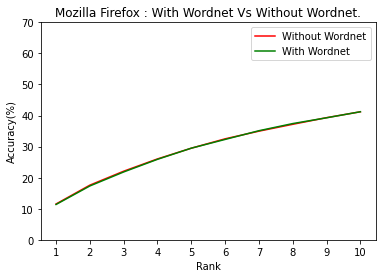

In [47]:
# x = range(1,12)
y = range(0,70)

plt.plot(rfc_accuracy_avg, color='red',label ='Without Wordnet')
plt.plot(rfc_accuracy_with_wordnet_avg, color='green',label ='With Wordnet')
plt.title('Mozilla Firefox : With Wordnet Vs Without Wordnet.')
plt.xlabel('Rank')
plt.ylabel('Accuracy(%)')
plt.xticks([r for r in range(10)],
        ['1', '2', '3', '4', '5','6', '7', '8', '9', '10'])
plt.yticks(np.arange(0, 80, 10))
plt.legend()
# plt.show()

plt.savefig('rf_word2vec_mf_with_or_without_wordnet.png')

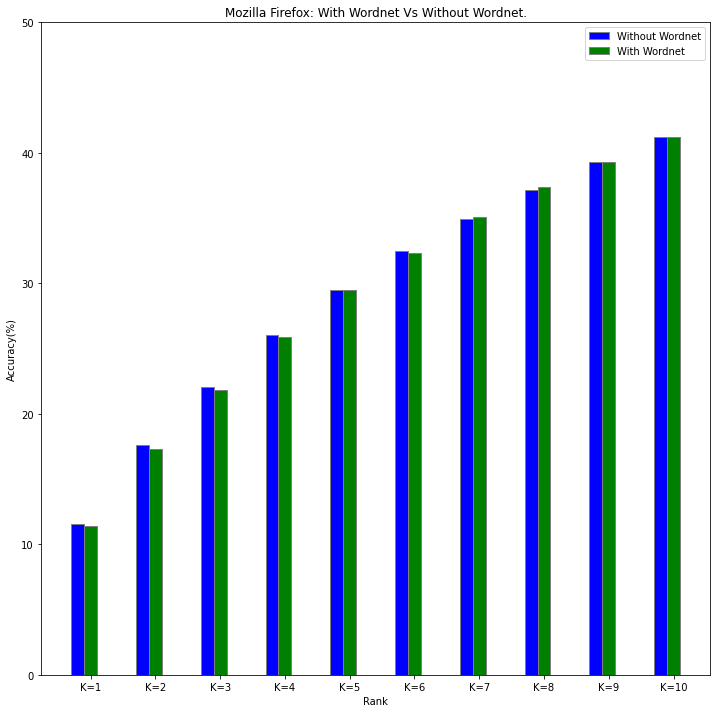

In [52]:
y = range(0,70)
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(12, 12))
 
# Set position of bar on X axis
br1 = np.arange(10)
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, rfc_accuracy_avg, color ='b', width = barWidth,
        edgecolor ='grey', label ='Without Wordnet')
plt.bar(br2, rfc_accuracy_with_wordnet_avg, color ='g', width = barWidth,
        edgecolor ='grey', label ='With Wordnet')
 
# Adding Xticks
plt.xlabel('Rank')
plt.ylabel('Accuracy(%)')
plt.xticks([r + barWidth for r in range(10)],
       ['K=1', 'K=2', 'K=3', 'K=4', 'K=5', 'K=6', 'K=7', 'K=8', 'K=9', 'K=10'])
plt.yticks(np.arange(0, 60, 10))

plt.title('Mozilla Firefox: With Wordnet Vs Without Wordnet.')
 
plt.legend()

# plt.show()

plt.savefig('mf_rf_with_or_without_wordnet.png')

In [49]:
rfc_accuracy_avg_rank = []
rfc_accuracy_with_wordnet_avg_rank = []

rfc_accuracy_avg_rank.append(rfc_accuracy_avg[0])
rfc_accuracy_avg_rank.append(rfc_accuracy_avg[4])
rfc_accuracy_avg_rank.append(rfc_accuracy_avg[9])

rfc_accuracy_with_wordnet_avg_rank.append(rfc_accuracy_with_wordnet_avg[0])
rfc_accuracy_with_wordnet_avg_rank.append(rfc_accuracy_with_wordnet_avg[4])
rfc_accuracy_with_wordnet_avg_rank.append(rfc_accuracy_with_wordnet_avg[9])

In [50]:
print(rfc_accuracy_avg_rank)
print(rfc_accuracy_with_wordnet_avg_rank)

[11.53, 29.49, 41.21]
[11.37, 29.5, 41.23]


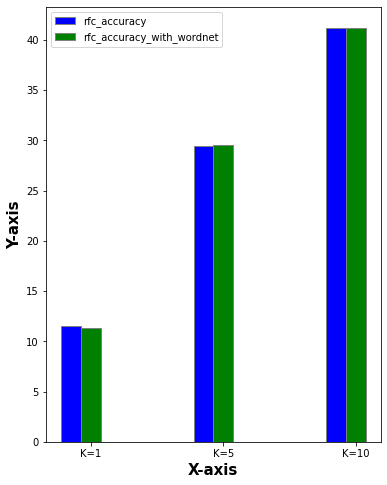

In [51]:
# set width of bar
barWidth = 0.15
fig = plt.subplots(figsize =(6, 8))
 
# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]


# Make the plot
plt.bar(br1, rfc_accuracy_avg_rank, color ='b', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy')
plt.bar(br2, rfc_accuracy_with_wordnet_avg_rank, color ='g', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_with_wordnet')
 
# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['K=1', 'K=5', 'K=10'])

# plt.title('Accuracy with or without wordnet (Rank 1, 5 and 10): BiDirectional Neural Network')
 
plt.legend()

# plt.show()

plt.savefig('Accuracy_Random_Forest_with_or_without_wordnet_bar_rank.png')